In [12]:
# Env: rive
# Audrey / Cindy /
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os
import tensorflow as tf # Machine learning

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K
from keras import regularizers

import pandas as pd
import numpy as np

# Chargement des librairies + données
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
cible = "turb"

echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv")

qualite_eau = echantillons.copy()
qualite_eau['annee'] = pd.to_datetime(qualite_eau['date']).dt.year
qualite_eau['mois'] = pd.to_datetime(qualite_eau['date']).dt.month
qualite_eau = qualite_eau[(qualite_eau['mois'] >= 6) & (qualite_eau['mois'] <= 9) & (qualite_eau['annee'] >= 2016)]
qualite_eau['ID'] = qualite_eau['no_station'].astype(str) + "_" + qualite_eau['annee'].astype(str)
qualite_eau['nom_fichier'] = qualite_eau['ID'] + ".png"
qualite_eau = qualite_eau.dropna(subset=[cible])
qualite_eau[cible] = StandardScaler().fit_transform(qualite_eau[[cible]])

/tmp/ipykernel_28658/2207651141.py:3: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv")


In [15]:
qualite_eau[cible]

19812    -0.224416
19813     0.038005
19814     0.084044
19819     0.130083
19820     1.373133
            ...   
132713    0.222161
132714    0.038005
132717    0.820666
132718    0.728589
132719   -0.026449
Name: turb, Length: 9372, dtype: float64

In [16]:
qualite_eau

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
19812,Q111972-99,210,06130005,2019-06-10T00:00:00Z,1000,NaN,18.0,3.0,4.73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,06130005_2019,06130005_2019.png
19813,Q113254-06,210,06130005,2019-07-15T00:00:00Z,1010,NaN,27.0,5.0,4.51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,7,06130005_2019,06130005_2019.png
19814,Q114228-99,210,06130005,2019-08-06T00:00:00Z,950,NaN,27.0,52.0,3.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,06130005_2019,06130005_2019.png
19819,Q120460-13,210,06130005,2020-07-13T00:00:00Z,1015,NaN,26.0,52.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,06130005_2020,06130005_2020.png
19820,Q122442-21,210,06130005,2020-09-14T00:00:00Z,700,NaN,27.0,84.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,06130005_2020,06130005_2020.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132713,Q114611-97,210,7710001,2019-08-13T00:00:00Z,912,NaN,15.0,430.0,2.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,7710001_2019,7710001_2019.png
132714,Q115919-20,210,7710001,2019-09-18T00:00:00Z,845,NaN,17.0,54.0,2.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,9,7710001_2019,7710001_2019.png
132717,Q120594-63,210,7710001,2020-07-14T00:00:00Z,1326,NaN,10.0,260.0,1.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,7710001_2020,7710001_2020.png
132718,Q121526-38,210,7710001,2020-08-11T00:00:00Z,1627,NaN,12.0,900.0,1.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,7710001_2020,7710001_2020.png


In [17]:
# Préparation des générateurs d'images
dossier_images = "../Imagerie/3km/"
colonne_noms_fichiers = "nom_fichier"
rescale_factor = 1/255
validation_fraction = 0.2
image_dimensions = (294, 201)
random_seed = int(np.round(np.random.uniform(0, 10000)))

train_data, val_data = train_test_split(qualite_eau, test_size=validation_fraction, random_state=random_seed)

In [18]:
train_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
132426,Q112047-99,210,5040006,2019-06-11T00:00:00Z,1200,NaN,14.0,4100.0,32.40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,5040006_2019,5040006_2019.png
67196,Q127852-04,210,02500002,2021-07-05T00:00:00Z,1229,NaN,31.0,52.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,7,02500002_2021,02500002_2021.png
62188,Q096017-71,210,03020081,2017-06-04T00:00:00Z,1630,NaN,NaN,26.0,6.74,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,6,03020081_2017,03020081_2017.png
68156,Q128786-06,230,03030324,2021-08-02T00:00:00Z,1425,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,8,03030324_2021,03030324_2021.png
65168,Q107228-78,210,04030001,2018-09-10T00:00:00Z,1150,NaN,NaN,160.0,0.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,04030001_2018,04030001_2018.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124624,Q096429-46,210,5010014,2017-06-13T00:00:00Z,1015,NaN,NaN,5.0,1.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,6,5010014_2017,5010014_2017.png
131469,Q121529-60,210,4010001,2020-08-11T00:00:00Z,1550,NaN,12.0,4500.0,1.87,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,4010001_2020,4010001_2020.png
71313,Q130199-72,210,05390001,2021-09-14T00:00:00Z,641,NaN,71.0,430.0,1.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,9,05390001_2021,05390001_2021.png
126676,Q107242-08,210,4290002,2018-09-10T00:00:00Z,1230,NaN,NaN,88.0,1.89,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,4290002_2018,4290002_2018.png


In [19]:
val_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
121973,Q088582-56,210,03010046,2016-06-07T00:00:00Z,940,NaN,NaN,700.0,3.61,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,6,03010046_2016,03010046_2016.png
72537,Q130310-15,210,07020002,2021-09-14T00:00:00Z,1624,NaN,3.9,3.0,0.42,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,9,07020002_2021,07020002_2021.png
67469,Q114234-55,210,03010009,2019-08-06T00:00:00Z,1015,NaN,32.0,16.0,3.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,03010009_2019,03010009_2019.png
69957,Q127879-04,230,03090125,2021-07-06T00:00:00Z,1300,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,7,03090125_2021,03090125_2021.png
127646,Q090878-59,210,05040143,2016-08-16T00:00:00Z,1149,NaN,NaN,320.0,4.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,8,05040143_2016,05040143_2016.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99241,Q096853-28,210,03030003,2017-07-03T00:00:00Z,1225,NaN,NaN,400.0,2.52,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,7,03030003_2017,03030003_2017.png
61331,Q090590-29,210,6290012,2016-08-08T00:00:00Z,930,NaN,NaN,1.0,0.90,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,8,6290012_2016,6290012_2016.png
60184,Q089812-36,210,4010010,2016-07-12T00:00:00Z,1257,NaN,NaN,230.0,1.66,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,7,4010010_2016,4010010_2016.png
127291,Q105418-86,210,05300035,2018-07-17T00:00:00Z,950,NaN,NaN,240.0,5.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,7,05300035_2018,05300035_2018.png


In [20]:
datagen = ImageDataGenerator(rescale=rescale_factor)

training_generator = datagen.flow_from_dataframe(
    train_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    subset="training",
    seed=random_seed
)

validation_generator = datagen.flow_from_dataframe(
    val_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    subset="validation",
    seed=random_seed
)

Found 5576 validated image filenames.
Found 0 validated image filenames.


/home/lalandmi/miniconda3/envs/rive/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1921 invalid image filename(s) in x_col="nom_fichier". These filename(s) will be ignored.
  warnings.warn(
/home/lalandmi/miniconda3/envs/rive/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 495 invalid image filename(s) in x_col="nom_fichier". These filename(s) will be ignored.
  warnings.warn(


In [24]:
# Préparation et ajustement du modèle
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(image_dimensions[0], image_dimensions[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation="relu", kernel_regularizer=regularizers.L2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1)
])

def r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

In [25]:
model.compile(optimizer="adam", loss="mse", metrics=["mae", r2])

In [26]:

# Exploration des résultats
history = model.fit(
    x=training_generator,
    validation_data=validation_generator,
    epochs=10,
    batch_size = 10
)

Epoch 1/10
175/175 [==============================] - 224s 1s/step - loss: 1.0927 - mae: 0.4616 - r2: -0.1185
Epoch 2/10
175/175 [==============================] - 213s 1s/step - loss: 1.0836 - mae: 0.4633 - r2: -0.2145
Epoch 3/10
175/175 [==============================] - 222s 1s/step - loss: 1.0815 - mae: 0.4628 - r2: -0.0893
Epoch 4/10
175/175 [==============================] - 238s 1s/step - loss: 1.0802 - mae: 0.4634 - r2: -0.1478
Epoch 5/10
175/175 [==============================] - 242s 1s/step - loss: 1.0793 - mae: 0.4616 - r2: -0.1233
Epoch 6/10
175/175 [==============================] - 188s 1s/step - loss: 1.0787 - mae: 0.4627 - r2: -0.1154
Epoch 7/10
175/175 [==============================] - 158s 899ms/step - loss: 1.0783 - mae: 0.4598 - r2: -0.1580
Epoch 8/10
175/175 [==============================] - 98s 556ms/step - loss: 1.0780 - mae: 0.4622 - r2: -0.0722
Epoch 9/10
175/175 [==============================] - 100s 571ms/step - loss: 1.0779 - mae: 0.4648 - r2: -0.1225
Ep

In [27]:
history.history

{'loss': [1.0926859378814697,
  1.0836255550384521,
  1.0815011262893677,
  1.0801992416381836,
  1.0793428421020508,
  1.0787261724472046,
  1.078348159790039,
  1.077980637550354,
  1.0779054164886475,
  1.0777181386947632],
 'mae': [0.4615943431854248,
  0.46327120065689087,
  0.4628104865550995,
  0.4634149968624115,
  0.46162310242652893,
  0.4627404808998108,
  0.45978137850761414,
  0.46220582723617554,
  0.46482208371162415,
  0.46072110533714294],
 'r2': [-0.11852724105119705,
  -0.21445196866989136,
  -0.08926016092300415,
  -0.14783212542533875,
  -0.12332697957754135,
  -0.11544721573591232,
  -0.15799957513809204,
  -0.07221577316522598,
  -0.12250904738903046,
  -0.12283729761838913]}

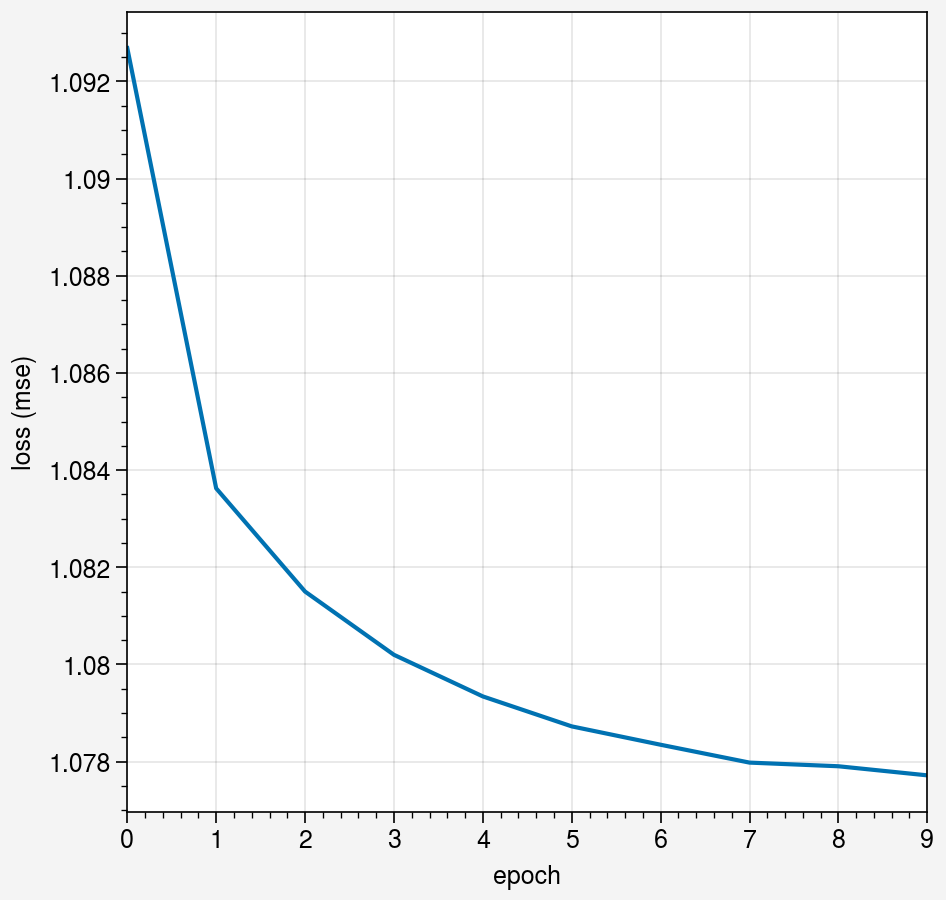

In [28]:
fig, axs = pplt.subplots(ncols=1, nrows=1, refwidth=4)

axs[0].plot(history.history['loss'])
axs[0].format(xlabel='epoch', ylabel='loss (mse)')